# Create a synthetic dataset of picture that do not contain images

- use the house numbers pictures, take each 32x32 frames in the corner of the images as synthetic data

# Load the house model dataset, take 4 corners in images that are larger than some defined size

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import os 
import scipy.io as sio
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import re
import numpy as np
from SVHNDataset import SVHNDataset
from sklearn.utils import shuffle
import tensorflow as tf
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # otherwise there will be an error

# list of the image files in the training set
folder_images = '/Users/hkromer/02_PhD/02_Data/12.dcr/Stanford_housenumbers/train/'

files_images = os.listdir(folder_images)
files_images = [f"{folder_images}{f}" for f in files_images if f.endswith('png')]

# load images
images = []
#4 corners
framesize = 32
# can be made a lot more efficient using numpy arrays
images_corners = np.empty([4*len(files_images),framesize,framesize]) # it will be at most 4 times the size of the original images

jj = 0 # index in images_corners
for ii, file in enumerate(files_images):
    img = cv2.imread(file, 0) #grayscale
    # convert to grayscale
    width = img.shape[1]
    height = img.shape[0]
    # take only images that are significantly larger so that there will not be too much of the digit in the image
    if (width > 50) & (height > 50):
        images.append(img)
        # extrat the 4 corners in each image

        # left positions of the corner
        c1 = img[0:framesize,0:framesize].copy() # top left
        c2 = img[0:framesize,width-framesize:].copy() # top right
        c3 = img[height-framesize:,0:framesize].copy() # bottom left
        c4 = img[height-framesize:,width-framesize:].copy() # bottom right
        images_corners[jj] = c1
        jj += 1
        images_corners[jj] = c2
        jj += 1
        images_corners[jj] = c3
        jj += 1
        images_corners[jj] = c4
        jj += 1

# not all the images satisfied the width and height criteria, adjust the images_corner array
s = np.sum(np.sum(images_corners,axis=1),axis=1)
s_limit = s[s>0].shape[0]

images_corners = images_corners[0:s_limit,:,:]

print(f'Loaded images in the corner, shape of dataset: {images_corners.shape}')

Loaded images in the corner, shape of dataset: (59884, 32, 32)


# Create dataset for training

In [4]:
svhn = SVHNDataset()


data_negative = images_corners.copy() # this will be y = 0 class

# preprocessing for keras, because it wants image numbers, frame, frame, channels
data_negative = data_negative.reshape(-1,32,32,1)

print('After preprocessing reshaping: ')
print(f'Negative dataset: {data_negative.shape}')


# load the dataset with the house numbers from SVHN
# these do all contain numbers, so that will be the positive dataset, y=1

path_train  = '/Users/hkromer/02_PhD/02_Data/12.dcr/Stanford_housenumbers/train_32x32.mat'
path_test  = '/Users/hkromer/02_PhD/02_Data/12.dcr/Stanford_housenumbers/test_32x32.mat'

train_data, train_labels, test_data, test_labels = svhn.load_dataset(path_train, path_test)
# convert to grayscale
train_data = svhn.convert_to_gray(train_data)
test_data = svhn.convert_to_gray(test_data)
print(' ')
print('After conversion to grayscale: ')
print(f'Original SVHN train data: {train_data.shape}, labels: {train_labels.shape}')
print(f'Original SVHN test data: {test_data.shape}, labels: {test_labels.shape}')

X_train = svhn.preprocess_for_KERAS_reshaping(32, train_data)
X_test = svhn.preprocess_for_KERAS_reshaping(32, test_data)
print(' ')
print('After preprocessing reshaping: ')
print(f'Original SVHN train data: {X_train.shape}')
print(f'Original SVHN test data: {X_test.shape}')

# combine the original test and train dataset into one
data_positive = np.concatenate((X_train, X_test))

print(' ')
print(f'Positive dataset: {data_positive.shape}')

# shuffle the positive and the negative dataset
np.random.shuffle(data_positive)
np.random.shuffle(data_negative)

# make the two classes equal
data_positive = data_positive[0:data_negative.shape[0],:,:,:]
print(' ')
print('Made two classes equal in size')
print(f'Positive dataset: {data_positive.shape}')
print(f'Negative dataset: {data_negative.shape}')

labels_negative = np.zeros(data_negative.shape[0]) # y = 0
labels_positive = np.ones(data_positive.shape[0]) # y = 0

# join the two classes
X = np.concatenate((data_positive,data_negative))
y = np.concatenate((labels_positive,labels_negative))

# shuffle
X, y = shuffle(X, y, random_state=0)

print(' ')
print('Shuffled and joined the classes')
print(f'Features X: {X.shape}, labels y: {y.shape}')

After preprocessing reshaping: 
Negative dataset: (59884, 32, 32, 1)
Train data: (32, 32, 3, 73257) , Train labels: (73257, 1)
Test data: (32, 32, 3, 26032) , Test labels: (26032, 1)
 
After conversion to grayscale: 
Original SVHN train data: (32, 32, 73257), labels: (73257, 1)
Original SVHN test data: (32, 32, 26032), labels: (26032, 1)
 
After preprocessing reshaping: 
Original SVHN train data: (73257, 32, 32, 1)
Original SVHN test data: (26032, 32, 32, 1)
 
Positive dataset: (99289, 32, 32, 1)
 
Made two classes equal in size
Positive dataset: (59884, 32, 32, 1)
Negative dataset: (59884, 32, 32, 1)
 
Shuffled and joined the classes
Features X: (119768, 32, 32, 1), labels y: (119768,)


# Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (80244, 32, 32, 1), y_train: (80244,)
X_test: (39524, 32, 32, 1), y_test: (39524,)


# Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax') # either 1 or 0
])

# define the optimizer, loss function and metrics for the network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# start training
history = model.fit(X_train, y_train, epochs=10)

import tensorflow as tf
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # otherwise there will be an error

model.save('/Users/hkromer/02_PhD/02_Data/12.dcr/Stanford_housenumbers/2019-19-25.KERAS_model_DigitDetector.h5')

Train on 80244 samples
Epoch 1/10
80244/80244 [==============================] - 130s 2ms/sample - loss: 0.2686 - accuracy: 0.9203
Epoch 2/10
80244/80244 [==============================] - 133s 2ms/sample - loss: 0.1412 - accuracy: 0.9487
Epoch 3/10
80244/80244 [==============================] - 134s 2ms/sample - loss: 0.1289 - accuracy: 0.9539
Epoch 4/10
80244/80244 [==============================] - 133s 2ms/sample - loss: 0.1153 - accuracy: 0.9577
Epoch 5/10
80244/80244 [==============================] - 135s 2ms/sample - loss: 0.1094 - accuracy: 0.9605
Epoch 6/10
80244/80244 [==============================] - 138s 2ms/sample - loss: 0.1002 - accuracy: 0.9637
Epoch 7/10
80244/80244 [==============================] - 139s 2ms/sample - loss: 0.0959 - accuracy: 0.9662
Epoch 8/10
80244/80244 [==============================] - 137s 2ms/sample - loss: 0.0918 - accuracy: 0.9673
Epoch 9/10
80244/80244 [==============================] - 137s 2ms/sample - loss: 0.0921 - accuracy: 0.9678
Epoch

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print("Model accuracy on test data is: {:6.3f}%".format(100 * acc))

In [6]:
import tensorflow as tf
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # otherwise there will be an error
path = '/Users/hkromer/02_PhD/02_Data/12.dcr/Stanford_housenumbers/2019-19-25.KERAS_model_DigitDetector.h5'

model = svhn.load_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0

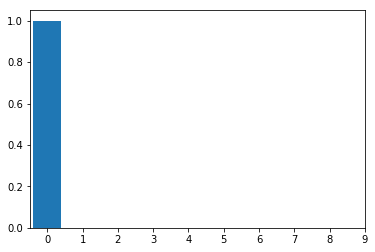

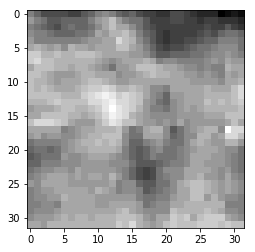

0.0


In [7]:
ii = 9
examples = X_test[ii,:,:]
examples = examples.astype(np.float64)
examples = examples.reshape(-1,32,32,1)
y_predict = model.predict(examples)[0]
y_example = y_test[ii]
X = [a for a in range(0,len(y_predict))]

plt.bar(X,y_predict)
plt.xticks(np.arange(0,10,1))
plt.show()


examples=examples.reshape(32,32)
plt.imshow(examples,cmap='gray')
plt.show()
print(y_example)